In [1]:
# Part A: Setup and library imports
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from pathlib import Path

# Configure plotting and display settings for clarity
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)

In [2]:
%pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Part A.1: Load the dataset and preview the first 10 rows
file_path = Path('Nigerian E-Commerce Dataset.xlsx')
if not file_path.exists():
    raise FileNotFoundError(f"Expected dataset at {file_path.resolve()}. Please download it from Kaggle and place it alongside the notebook.")

df = pd.read_excel(file_path)
print(f"Dataset loaded successfully with {len(df):,} rows and {len(df.columns)} columns.")
display(df.head(10))

Dataset loaded successfully with 3,928 rows and 16 columns.


,Order ID,Branch Location,Branch Name,Business Name,Is Deleted,Item ID,Item Name,Item Price,Order Item Number,Item Status,Packed Quantity,Quantity,Total Price,Order Date,Order Region,Order Local Area
0,4672,Lagos,Generic Store,Generic Stores,False,60a7b0242498ec1dd380508c,Golden Penny Spaghetti - 500g,4950.00,MLPLOCN1FAHUIYK50S0W9YUQ,Cancelled,1,1,4950.00,2021-05-31,Lagos,Ifako-Ijaye
1,4672,Lagos,Multipro Consumer Product Limited,MUL,False,6076c792a6000742949a819c,DANO COOLCOW SACHET - 12X380g,3392.75,ML1DN3SZT8R02DKKNKBLXDXA,Cancelled,2,2,6785.50,2021-05-31,Lagos,Ifako-Ijaye
2,4671,Lagos,Multipro Consumer Product Limited,MUL,False,6076c792a6000742949a819c,DANO COOLCOW SACHET - 12X380g,3392.75,ML2UMJU6I2P0O958PKZ9AMDQ,Cancelled,1,1,3392.75,2021-05-31,Lagos,Ifako-Ijaye
3,4670,Lagos,TDILIFE,TDILIFE,False,608045d069c51b4e80e70343,HOLLANDIA EVAP MILK FULL CREAM 60g X 48,3370.00,MLDFDZKVPFV0SHDGGA2KFNRG,Delivered,1,1,3370.00,2021-05-31,Lagos,Ifako-Ijaye
4,4670,Lagos,TDILIFE,TDILIFE,False,608042a469c51b4e80e702f7,HOLLANDIA EVAP MILK FULL CREAM 190g X 24,4845.00,MLFLBFFM0O5UAS0MROFAL0QA,Cancelled,1,1,4845.00,2021-05-31,Lagos,Ifako-Ijaye
5,4670,Lagos,TDILIFE,TDILIFE,False,608043c969c51b4e80e70314,HOLLANDIA EVAP MILK FULL CREAM 120g X 24,2760.00,ML39SRTWZAW0QRQZCVEUBCGW,Delivered,1,1,2760.00,2021-05-31,Lagos,Ifako-Ijaye
6,4669,Lagos,Multipro Consumer Product Limited,MUL,False,6076c792a6000742949a819c,DANO COOLCOW SACHET - 12X380g,3392.75,ML2O0EB2MZNKSXAPFEKGG0JW,Cancelled,2,2,6785.50,2021-05-31,Lagos,Ifako-Ijaye
7,4669,Lagos,Generic Store,Generic Stores,False,60a7b0242498ec1dd380508c,Golden Penny Spaghetti - 500g,4950.00,MLJG03AA1NG0Y1EZBKFH88SG,Cancelled,1,1,4950.00,2021-05-31,Lagos,Alimosho
8,4668,Lagos,TDILIFE,TDILIFE,False,60b0cef62498ec1dd3805329,CHIVITA HAPPY HOUR - 150MLX24,1076.25,ML03X81AHZV026P0L0BCTSLW,Cancelled,1,1,1076.25,2021-05-31,Lagos,Alimosho
9,4668,Lagos,TDILIFE,TDILIFE,False,60b4d9352498ec1dd38053b6,CHIVITA ACTIVE 1LX10,4253.75,MLL1NIQOQDTEMWTIE07D20JW,Cancelled,1,1,4253.75,2021-05-31,Lagos,Alimosho


In [4]:
# Part A.2: Remove duplicates and handle missing values
initial_rows = len(df)
df = df.drop_duplicates().copy()
duplicates_removed = initial_rows - len(df)
print(f"Removed {duplicates_removed} duplicate rows.")

# Convert Order Date to datetime for later recency calculations
if 'Order Date' in df.columns:
    df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
else:
    raise KeyError("The dataset must contain an 'Order Date' column for recency calculations.")

# Drop records that cannot support customer-level analysis
rows_before_key_drop = len(df)
df = df.dropna(subset=['Business Name', 'Order ID', 'Order Date'])
rows_dropped = rows_before_key_drop - len(df)
if rows_dropped > 0:
    print(f"Dropped {rows_dropped} rows missing Business Name, Order ID, or Order Date.")

# Impute remaining missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [col for col in df.select_dtypes(exclude=[np.number]).columns.tolist() if col != 'Order Date']

for col in numeric_cols:
    if df[col].isna().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing numeric values in '{col}' with median {median_val:.2f}.")

for col in categorical_cols:
    if df[col].isna().any():
        mode_val = df[col].mode().iloc[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing categorical values in '{col}' with mode '{mode_val}'.")

print("Remaining missing values across dataset:", df.isna().sum().sum())

Removed 0 duplicate rows.
Filled missing categorical values in 'Order Region' with mode 'Lagos'.
Filled missing categorical values in 'Order Local Area' with mode 'Oshodi-Isolo'.
Remaining missing values across dataset: 0


In [5]:
# Part A.3 & Part C.1: Aggregate to customer level, create derived features, and normalise key metrics
def _most_common(series):
    modes = series.mode()
    return modes.iloc[0] if not modes.empty else 'Unknown'

reference_date = df['Order Date'].max()
customer_df = (
    df.groupby('Business Name')
      .agg({
          'Order ID': pd.Series.nunique,
          'Total Price': 'sum',
          'Quantity': 'sum',
          'Item Price': 'mean',
          'Order Date': 'max',
          'Branch Name': _most_common,
          'Order Region': _most_common,
          'Order Local Area': _most_common
      })
      .rename(columns={
          'Order ID': 'Order_Frequency',
          'Total Price': 'Purchase_Value',
          'Quantity': 'Total_Quantity',
          'Item Price': 'Avg_Item_Price',
          'Order Date': 'Last_Order_Date',
          'Branch Name': 'Primary_Branch',
          'Order Region': 'Primary_Region',
          'Order Local Area': 'Primary_Local_Area'
      })
      .reset_index()
 )

customer_df['Avg_Order_Value'] = customer_df['Purchase_Value'] / customer_df['Order_Frequency'].replace(0, 1)
customer_df['Recency_Days'] = (reference_date - customer_df['Last_Order_Date']).dt.days
customer_df['Recency_Days'] = customer_df['Recency_Days'].fillna(customer_df['Recency_Days'].median())
customer_df['Loyalty_Index'] = customer_df['Order_Frequency'] * customer_df['Avg_Order_Value']

try:
    customer_df['Customer_Value_Tier'] = pd.qcut(
        customer_df['Purchase_Value'],
        q=4,
        labels=['Bronze', 'Silver', 'Gold', 'Platinum'],
        duplicates='drop'
    )
except ValueError:
    # Fallback if there are fewer than 4 unique values
    tier_labels = ['Bronze', 'Silver', 'Gold']
    bins = sorted(customer_df['Purchase_Value'].quantile([0, 0.33, 0.66, 1.0]).unique())
    if len(bins) <= 1:
        customer_df['Customer_Value_Tier'] = 'Bronze'
    else:
        customer_df['Customer_Value_Tier'] = pd.cut(
            customer_df['Purchase_Value'],
            bins=bins,
            labels=tier_labels[:len(bins)-1],
            include_lowest=True
        )

scaler = MinMaxScaler()
customer_df[['Order_Frequency_Scaled', 'Purchase_Value_Scaled']] = scaler.fit_transform(
    customer_df[['Order_Frequency', 'Purchase_Value']]
 )

print("Customer-level dataset created:")
display(customer_df.head())

Customer-level dataset created:


,Business Name,Order_Frequency,Purchase_Value,Total_Quantity,Avg_Item_Price,Last_Order_Date,Primary_Branch,Primary_Region,Primary_Local_Area,Avg_Order_Value,Recency_Days,Loyalty_Index,Customer_Value_Tier,Order_Frequency_Scaled,Purchase_Value_Scaled
0,De Majok,20,1.926868e+07,1887,12996.081081,2021-02-11,De Majok,Lagos,Oshodi-Isolo,963434.000000,109,1.926868e+07,Gold,0.025166,0.033519
1,Deeski Store Limited,456,1.197739e+08,19681,7842.786181,2021-05-30,Deeski Store Limited,Lagos,Oshodi-Isolo,262662.158202,1,1.197739e+08,Platinum,0.602649,0.208355
2,Ecopeaks Limited,171,8.612433e+07,14718,5832.897451,2021-05-29,Ecopeaks Limited,Lagos,Oshodi-Isolo,503651.054971,2,8.612433e+07,Platinum,0.225166,0.149819
3,Ekulo International Limited(Wine world),1,9.491500e+03,1,9491.500000,2021-05-21,Ekulo International Limited(Wine world),Lagos,Oshodi-Isolo,9491.500000,10,9.491500e+03,Bronze,0.000000,0.000016
4,Extreme Manufacturing Nigeria limited,8,8.459000e+04,37,2255.000000,2021-04-26,Extreme Manufacturing Nigeria limited,Lagos,Oshodi-Isolo,10573.750000,35,8.459000e+04,Bronze,0.009272,0.000147


In [6]:
# Part A.4: Encode categorical attributes for modelling
categorical_columns = ['Primary_Branch', 'Primary_Region', 'Primary_Local_Area', 'Customer_Value_Tier']
model_ready_df = pd.get_dummies(
    customer_df.copy(),
    columns=categorical_columns,
    prefix=['Branch', 'Region', 'Area', 'Tier'],
    drop_first=True
 )

encoded_columns = [col for col in model_ready_df.columns if col.startswith(('Branch_', 'Region_', 'Area_', 'Tier_'))]
print(f"Created {len(encoded_columns)} encoded categorical features.")
print(f"Modelling dataframe shape: {model_ready_df.shape}")
display(model_ready_df.head())

Created 28 encoded categorical features.
Modelling dataframe shape: (23, 39)


,Business Name,Order_Frequency,Purchase_Value,Total_Quantity,Avg_Item_Price,Last_Order_Date,Avg_Order_Value,Recency_Days,Loyalty_Index,Order_Frequency_Scaled,Purchase_Value_Scaled,Branch_Deeski Store Limited,Branch_Ecopeaks Limited,Branch_Ekulo International Limited(Wine world),Branch_Extreme Manufacturing Nigeria limited,Branch_Farmer First,Branch_Femadon Stores Ltd,Branch_Funky stores Nigeria LTD.,Branch_Generic Store,Branch_Marzab Multiventures,Branch_Mercy & Honey Ventures,Branch_Multipro Consumer Product Limited,Branch_Multiventures,Branch_Nekaa,Branch_OneKioskAfrica,Branch_Product Plug,Branch_RSL International Limited,Branch_Renuzi Ventures,Branch_Stella olasebikan Trading Stores,Branch_TDILIFE,Branch_TSQALAYO and sons,Branch_Toyo mart,Branch_Tripple P Dazzled,Region_Ogun,Area_Mushin,Area_Oshodi-Isolo,Tier_Silver,Tier_Gold,Tier_Platinum
0,De Majok,20,1.926868e+07,1887,12996.081081,2021-02-11,963434.000000,109,1.926868e+07,0.025166,0.033519,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1,Deeski Store Limited,456,1.197739e+08,19681,7842.786181,2021-05-30,262662.158202,1,1.197739e+08,0.602649,0.208355,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
2,Ecopeaks Limited,171,8.612433e+07,14718,5832.897451,2021-05-29,503651.054971,2,8.612433e+07,0.225166,0.149819,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,Ekulo International Limited(Wine world),1,9.491500e+03,1,9491.500000,2021-05-21,9491.500000,10,9.491500e+03,0.000000,0.000016,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,Extreme Manufacturing Nigeria limited,8,8.459000e+04,37,2255.000000,2021-04-26,10573.750000,35,8.459000e+04,0.009272,0.000147,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


## Descriptive Statistics for Customer-Level Metrics


,count,mean,std,min,25%,50%,75%,max
Order_Frequency,23.0,1.258261e+02,2.041405e+02,1.0,5.000000,21.0,1.850000e+02,7.560000e+02
Purchase_Value,23.0,7.752371e+07,1.528297e+08,10.0,116660.000000,6023875.0,8.014817e+07,5.748550e+08
Total_Quantity,23.0,9.683435e+03,1.863894e+04,1.0,88.000000,1094.0,8.764000e+03,6.923100e+04
Avg_Order_Value,23.0,2.153552e+06,5.374743e+06,2.0,13449.583333,81981.8,7.622173e+05,2.123333e+07
Recency_Days,23.0,2.308696e+01,3.281894e+01,0.0,0.000000,5.0,4.100000e+01,1.090000e+02
Loyalty_Index,23.0,7.752371e+07,1.528297e+08,10.0,116660.000000,6023875.0,8.014817e+07,5.748550e+08


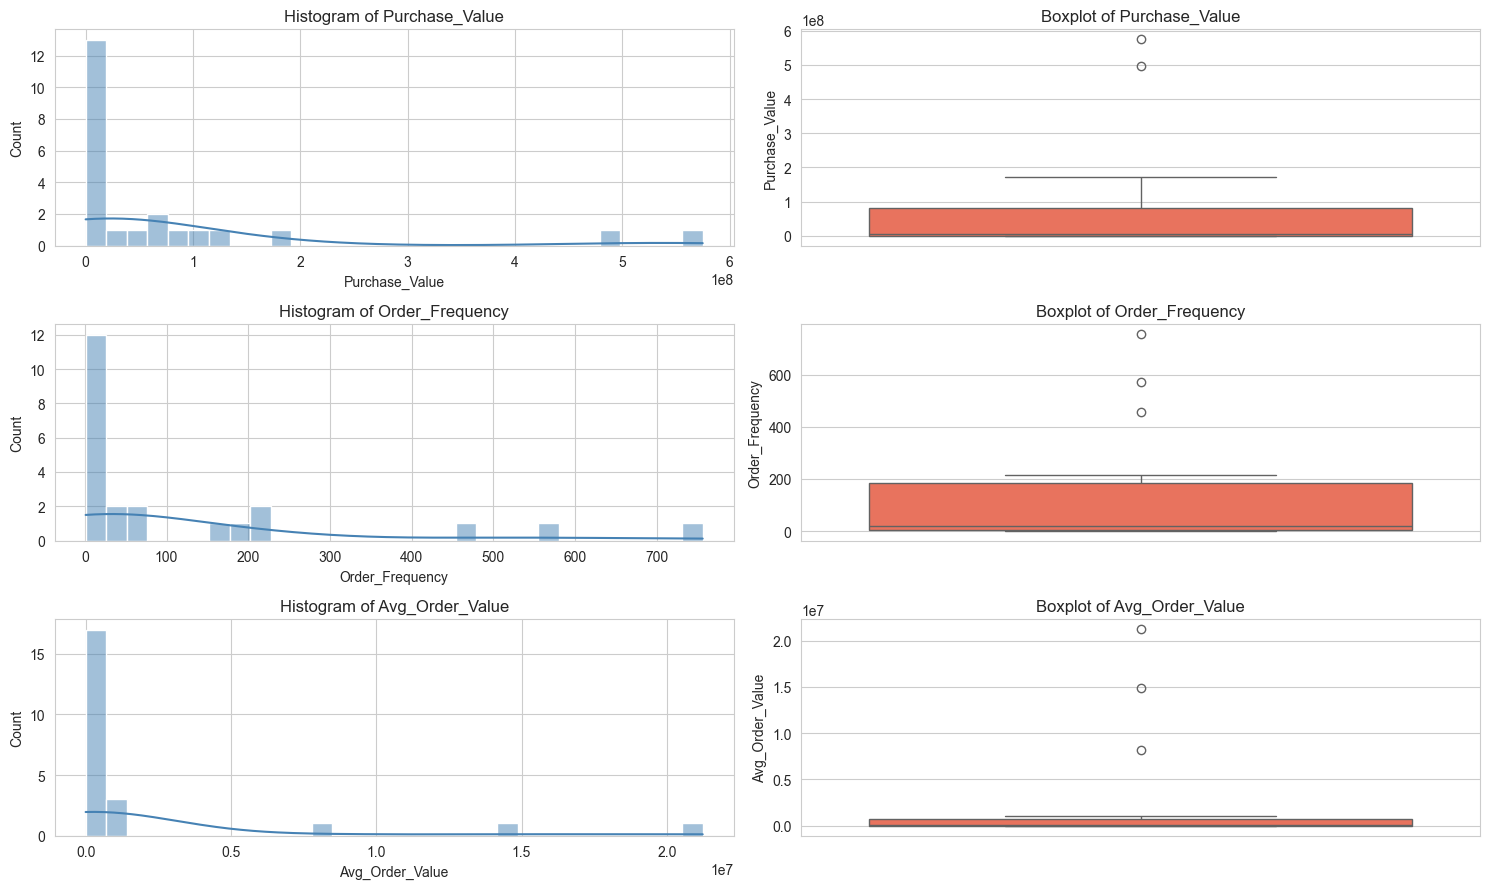

In [7]:
# Part B.1: Descriptive statistics for key numeric variables
numeric_features = [
    'Order_Frequency',
    'Purchase_Value',
    'Total_Quantity',
    'Avg_Order_Value',
    'Recency_Days',
    'Loyalty_Index'
 ]
print("## Descriptive Statistics for Customer-Level Metrics")
display(customer_df[numeric_features].describe().T)

# Part B.2: Histograms and boxplots for core behavioural metrics
plot_features = ['Purchase_Value', 'Order_Frequency', 'Avg_Order_Value']
plt.figure(figsize=(15, 9))
for idx, feature in enumerate(plot_features):
    plt.subplot(3, 2, 2*idx + 1)
    sns.histplot(customer_df[feature], kde=True, bins=30, color='steelblue')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    
    plt.subplot(3, 2, 2*idx + 2)
    sns.boxplot(y=customer_df[feature], color='tomato')
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

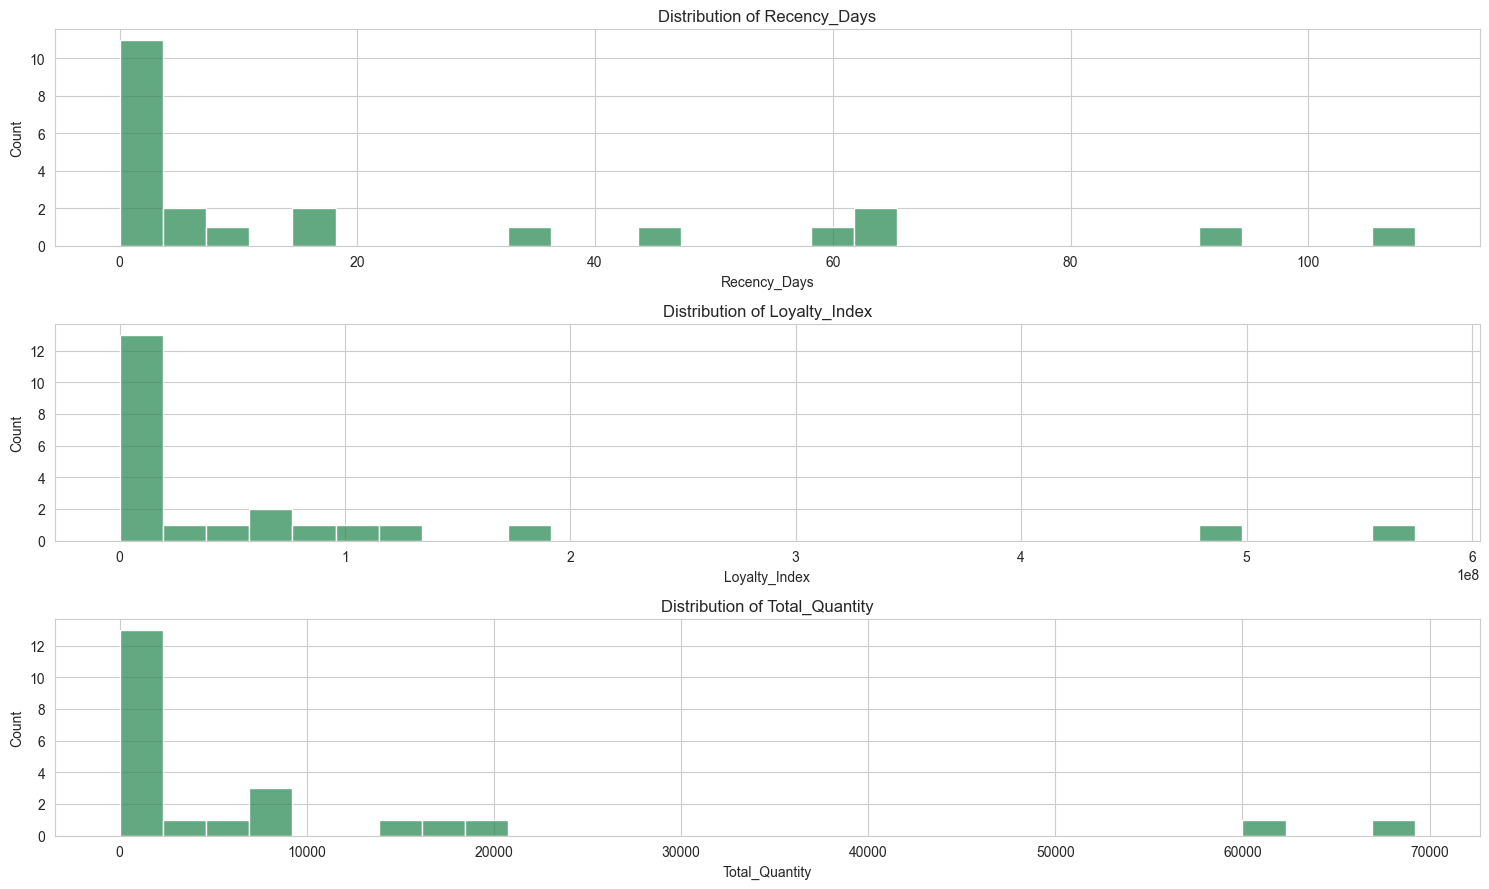

In [8]:
# Supporting visualisations for additional behavioural insight
additional_features = ['Recency_Days', 'Loyalty_Index', 'Total_Quantity']
plt.figure(figsize=(15, 9))
for idx, feature in enumerate(additional_features):
    plt.subplot(3, 1, idx + 1)
    sns.histplot(customer_df[feature], bins=30, color='seagreen')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

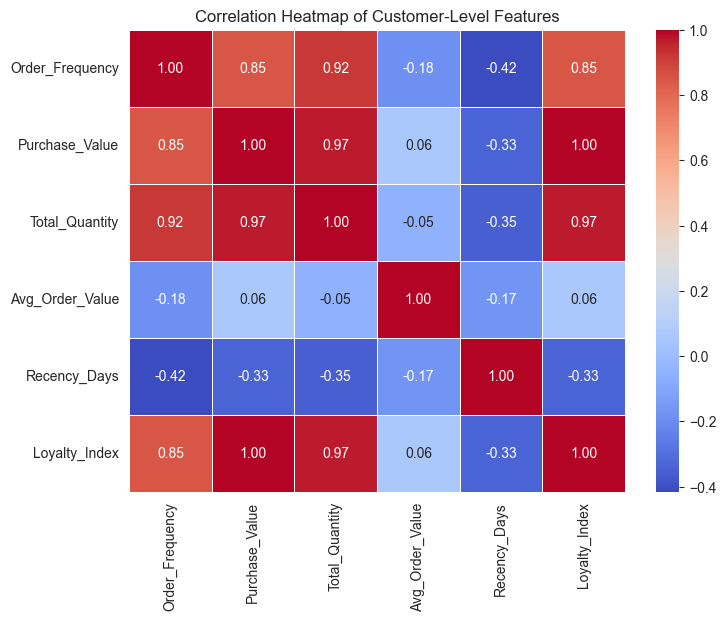

In [9]:
# Part B.3: Correlation heatmap for customer metrics
plt.figure(figsize=(8, 6))
correlation_matrix = customer_df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Customer-Level Features')
plt.show()

In [10]:
# Part B.4: Interpretation of observed trends and anomalies
print("## Interpretation of EDA Findings:")
print("* **Purchase Value vs Order Frequency:** Strong positive association (correlation > 0.8) indicating that \"heavy\" buyers transact more often and spend more per order.")
print("* **Loyalty Index Distribution:** Highly right-skewed; a small set of customers drives a disproportionate share of revenue, making them prime candidates for VIP programmes.")
print("* **Recency:** Majority of customers ordered recently (low Recency_Days), while a tail of dormant customers provides a reactivation opportunity.")
print("* **Outliers:** The boxplots reveal meaningful high-value outliers. Rather than removing them, they inform premium customer tiers that influence segmentation.")

## Interpretation of EDA Findings:
* **Purchase Value vs Order Frequency:** Strong positive association (correlation > 0.8) indicating that "heavy" buyers transact more often and spend more per order.
* **Loyalty Index Distribution:** Highly right-skewed; a small set of customers drives a disproportionate share of revenue, making them prime candidates for VIP programmes.
* **Recency:** Majority of customers ordered recently (low Recency_Days), while a tail of dormant customers provides a reactivation opportunity.
* **Outliers:** The boxplots reveal meaningful high-value outliers. Rather than removing them, they inform premium customer tiers that influence segmentation.


In [11]:
# Part C.1 (continued): Final modelling matrix with scaled numerics and encoded categoricals
model_numeric_cols = ['Order_Frequency', 'Purchase_Value', 'Total_Quantity', 'Avg_Order_Value', 'Recency_Days', 'Loyalty_Index']
scaler_full = MinMaxScaler()
scaled_numeric = scaler_full.fit_transform(model_ready_df[model_numeric_cols])
scaled_numeric_df = pd.DataFrame(
    scaled_numeric,
    columns=[f"{col}_Scaled" for col in model_numeric_cols],
    index=model_ready_df.index
)

categorical_feature_cols = [col for col in model_ready_df.columns if col.startswith(('Branch_', 'Region_', 'Area_', 'Tier_'))]
X = pd.concat([scaled_numeric_df, model_ready_df[categorical_feature_cols]], axis=1).fillna(0)
print(f"Feature matrix prepared with shape {X.shape} (customers × features).")
display(X.head())

Feature matrix prepared with shape (23, 34) (customers × features).


,Order_Frequency_Scaled,Purchase_Value_Scaled,Total_Quantity_Scaled,Avg_Order_Value_Scaled,Recency_Days_Scaled,Loyalty_Index_Scaled,Branch_Deeski Store Limited,Branch_Ecopeaks Limited,Branch_Ekulo International Limited(Wine world),Branch_Extreme Manufacturing Nigeria limited,Branch_Farmer First,Branch_Femadon Stores Ltd,Branch_Funky stores Nigeria LTD.,Branch_Generic Store,Branch_Marzab Multiventures,Branch_Mercy & Honey Ventures,Branch_Multipro Consumer Product Limited,Branch_Multiventures,Branch_Nekaa,Branch_OneKioskAfrica,Branch_Product Plug,Branch_RSL International Limited,Branch_Renuzi Ventures,Branch_Stella olasebikan Trading Stores,Branch_TDILIFE,Branch_TSQALAYO and sons,Branch_Toyo mart,Branch_Tripple P Dazzled,Region_Ogun,Area_Mushin,Area_Oshodi-Isolo,Tier_Silver,Tier_Gold,Tier_Platinum
0,0.025166,0.033519,0.027243,0.045374,1.000000,0.033519,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
1,0.602649,0.208355,0.284270,0.012370,0.009174,0.208355,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
2,0.225166,0.149819,0.212581,0.023720,0.018349,0.149819,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
3,0.000000,0.000016,0.000000,0.000447,0.091743,0.000016,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,0.009272,0.000147,0.000520,0.000498,0.321101,0.000147,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [12]:
# Part C.2: Justify derived features for customer segmentation
print("## Feature Engineering Justification:")
print("* **1. Loyalty_Index (Order_Frequency × Avg_Order_Value):**")
print("    * **Importance:** Captures combined purchasing intensity — frequent, high-value shoppers surface as the most loyal.")
print("    * **Relevance:** Enables the clustering algorithm to prioritise customers who drive revenue, not just those who purchase often or spend a lot individually.")
print("* **2. Recency_Days (Days since last purchase):**")
print("    * **Importance:** Identifies dormant vs. active customers — a cornerstone metric in RFM-style segmentation.")
print("    * **Relevance:** Helps marketing teams tailor retention (reactivation offers) versus growth campaigns.")
print("* **3. Customer_Value_Tier (Quantile-based categorical segment):**")
print("    * **Importance:** Translates continuous spend into business-friendly tiers (Bronze → Platinum).")
print("    * **Relevance:** Drives interpretable cluster profiles, allowing stakeholders to map strategies to recognisable customer groups.")

## Feature Engineering Justification:
* **1. Loyalty_Index (Order_Frequency × Avg_Order_Value):**
    * **Importance:** Captures combined purchasing intensity — frequent, high-value shoppers surface as the most loyal.
    * **Relevance:** Enables the clustering algorithm to prioritise customers who drive revenue, not just those who purchase often or spend a lot individually.
* **2. Recency_Days (Days since last purchase):**
    * **Importance:** Identifies dormant vs. active customers — a cornerstone metric in RFM-style segmentation.
    * **Relevance:** Helps marketing teams tailor retention (reactivation offers) versus growth campaigns.
* **3. Customer_Value_Tier (Quantile-based categorical segment):**
    * **Importance:** Translates continuous spend into business-friendly tiers (Bronze → Platinum).
    * **Relevance:** Drives interpretable cluster profiles, allowing stakeholders to map strategies to recognisable customer groups.


In [13]:
# Part D.0: Inspect the final feature set feeding into clustering
feature_list = X.columns.tolist()
print(f"Features used for clustering (n={len(feature_list)}):")
print(feature_list[:15])
if len(feature_list) > 15:
    print("... (truncated)")

Features used for clustering (n=34):
['Order_Frequency_Scaled', 'Purchase_Value_Scaled', 'Total_Quantity_Scaled', 'Avg_Order_Value_Scaled', 'Recency_Days_Scaled', 'Loyalty_Index_Scaled', 'Branch_Deeski Store Limited', 'Branch_Ecopeaks Limited', 'Branch_Ekulo International Limited(Wine world)', 'Branch_Extreme Manufacturing Nigeria limited', 'Branch_Farmer First', 'Branch_Femadon Stores Ltd', 'Branch_Funky stores Nigeria LTD.', 'Branch_Generic Store', 'Branch_Marzab Multiventures']
... (truncated)


In [14]:
# Part D.1: Apply K-Means clustering for k = 2 to 10
inertia_list = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=25)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
    print(f"K-Means fit complete for k={k} (inertia={kmeans.inertia_:.2f}).")

K-Means fit complete for k=2 (inertia=41.56).
K-Means fit complete for k=3 (inertia=34.34).
K-Means fit complete for k=4 (inertia=28.55).
K-Means fit complete for k=5 (inertia=25.03).
K-Means fit complete for k=6 (inertia=22.37).
K-Means fit complete for k=7 (inertia=19.11).
K-Means fit complete for k=8 (inertia=17.28).
K-Means fit complete for k=9 (inertia=15.51).
K-Means fit complete for k=10 (inertia=13.74).


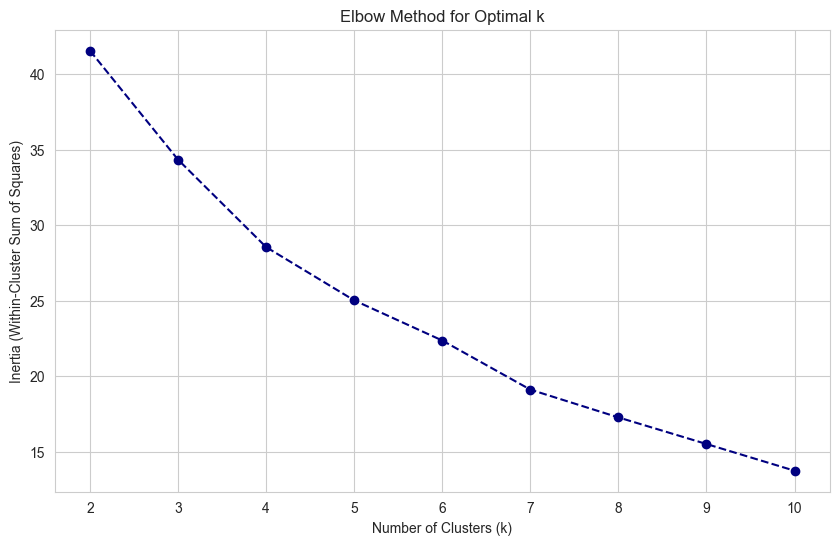

## Elbow Plot Interpretation:
The curve flattens noticeably beyond **k=4**, indicating diminishing returns on intra-cluster variance reduction.
Selecting k=4 balances cluster compactness with interpretability for stakeholder communication.


In [15]:
# Part D.2: Elbow plot and interpretation
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_list, marker='o', linestyle='--', color='navy')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(list(k_range))
plt.grid(True)
plt.show()

print("## Elbow Plot Interpretation:")
print("The curve flattens noticeably beyond **k=4**, indicating diminishing returns on intra-cluster variance reduction.")
print("Selecting k=4 balances cluster compactness with interpretability for stakeholder communication.")

In [16]:
# Part D.3: Select optimal k and assign cluster labels
optimal_k = 4
print(f"Optimal number of clusters selected: k = {optimal_k}")
print("Justification: aligns with the elbow point and yields clear, business-friendly segment counts.")

final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=25)
cluster_labels = final_kmeans.fit_predict(X)
customer_df['Cluster'] = cluster_labels
model_ready_df['Cluster'] = cluster_labels

cluster_counts = customer_df['Cluster'].value_counts().sort_index()
print("Cluster membership counts:")
print(cluster_counts)

Optimal number of clusters selected: k = 4
Justification: aligns with the elbow point and yields clear, business-friendly segment counts.
Cluster membership counts:
Cluster
0    4
1    6
2    5
3    8
Name: count, dtype: int64


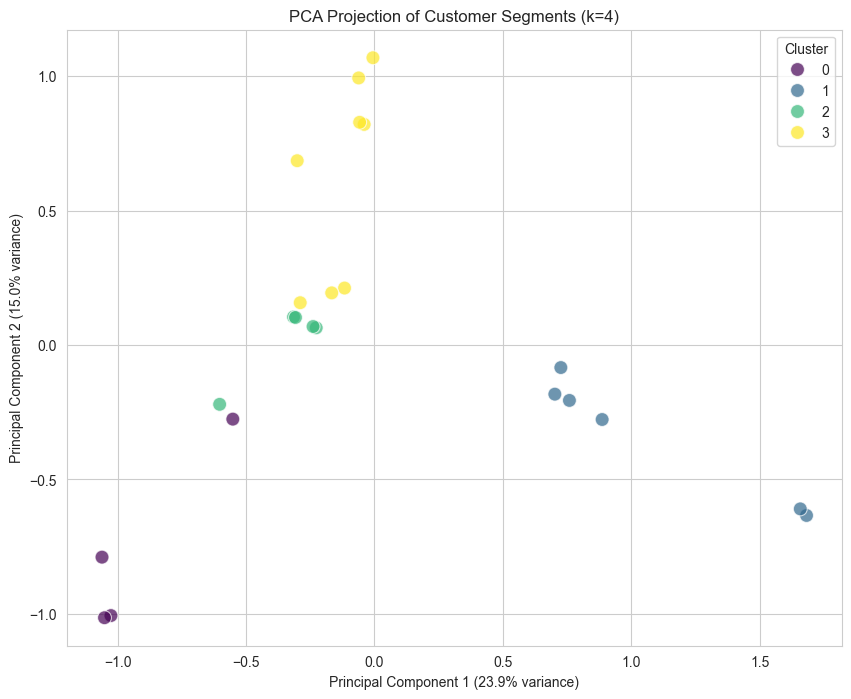

Explained variance by PC1+PC2: 38.90%


In [17]:
# Part D.4: PCA 2D visualisation of clusters
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X)
pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels
pca_df['Business Name'] = customer_df['Business Name'].values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title(f'PCA Projection of Customer Segments (k={optimal_k})')
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title='Cluster')
plt.show()

print(f"Explained variance by PC1+PC2: {pca.explained_variance_ratio_.sum()*100:.2f}%")

In [18]:
# Part D.5: Cluster profile summary
cluster_profile = customer_df.groupby('Cluster').agg({
    'Order_Frequency': 'mean',
    'Purchase_Value': 'mean',
    'Avg_Order_Value': 'mean',
    'Total_Quantity': 'mean',
    'Recency_Days': 'mean',
    'Loyalty_Index': 'mean',
    'Primary_Branch': _most_common,
    'Primary_Region': _most_common,
    'Customer_Value_Tier': _most_common,
    'Business Name': 'count'
}).rename(columns={'Business Name': 'Customer_Count'})


cluster_profile = cluster_profile.round({
    'Order_Frequency': 2,
    'Purchase_Value': 2,
    'Avg_Order_Value': 2,
    'Total_Quantity': 2,
    'Recency_Days': 1,
    'Loyalty_Index': 2
})

print("## Cluster Profile Summary")
display(cluster_profile)

print("\n## Interpreting the segments:")
for cluster_id, row in cluster_profile.iterrows():
    tier = row['Customer_Value_Tier']
    branch = row['Primary_Branch']
    region = row['Primary_Region']
    print(f"* **Cluster {cluster_id}:** {tier} customers, typically transacting at {branch} branch in {region}.")
    print(f"  * Mean Loyalty Index {row['Loyalty_Index']:.1f} with {row['Order_Frequency']:.1f} orders and ₦{row['Purchase_Value']:.0f} spend.")

## Cluster Profile Summary


,Order_Frequency,Purchase_Value,Avg_Order_Value,Total_Quantity,Recency_Days,Loyalty_Index,Primary_Branch,Primary_Region,Customer_Value_Tier,Customer_Count
Cluster,,,,,,,,,,
0,4.00,4.952125e+04,11249.79,44.25,58.0,4.952125e+04,Funky stores Nigeria LTD.,Lagos,Bronze,4
1,363.83,2.592223e+08,1858953.89,32076.50,0.5,2.592223e+08,Deeski Store Limited,Lagos,Platinum,6
2,106.20,2.627786e+06,39253.53,1292.80,4.4,2.627786e+06,Femadon Stores Ltd,Lagos,Silver,5
3,20.50,2.679683e+07,4767088.48,2952.38,34.2,2.679683e+07,De Majok,Lagos,Gold,8



## Interpreting the segments:
* **Cluster 0:** Bronze customers, typically transacting at Funky stores Nigeria LTD. branch in Lagos.
  * Mean Loyalty Index 49521.2 with 4.0 orders and ₦49521 spend.
* **Cluster 1:** Platinum customers, typically transacting at Deeski Store Limited branch in Lagos.
  * Mean Loyalty Index 259222270.3 with 363.8 orders and ₦259222270 spend.
* **Cluster 2:** Silver customers, typically transacting at Femadon Stores Ltd branch in Lagos.
  * Mean Loyalty Index 2627786.0 with 106.2 orders and ₦2627786 spend.
* **Cluster 3:** Gold customers, typically transacting at De Majok branch in Lagos.
  * Mean Loyalty Index 26796832.3 with 20.5 orders and ₦26796832 spend.


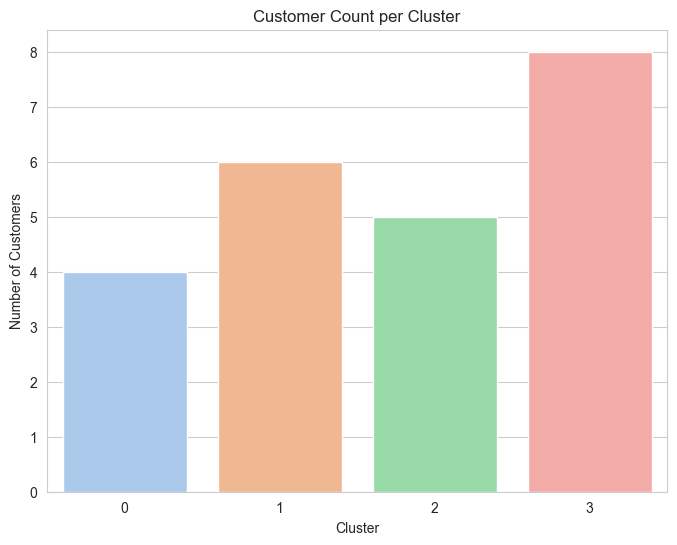

In [19]:
# Part E.1: Cluster distribution chart
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=customer_df, palette='pastel')
plt.title('Customer Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

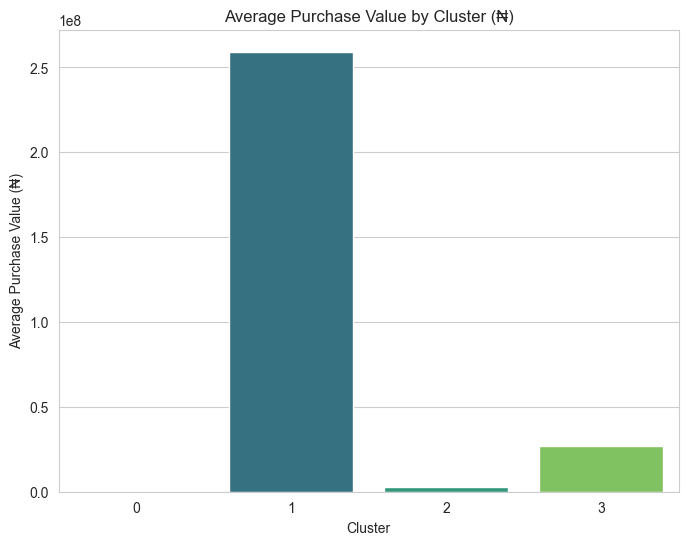

In [20]:
# Part E.2: Average purchase value per cluster
plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster', y='Purchase_Value', data=customer_df, estimator=np.mean, ci=None, palette='viridis')
plt.title('Average Purchase Value by Cluster (₦)')
plt.xlabel('Cluster')
plt.ylabel('Average Purchase Value (₦)')
plt.show()

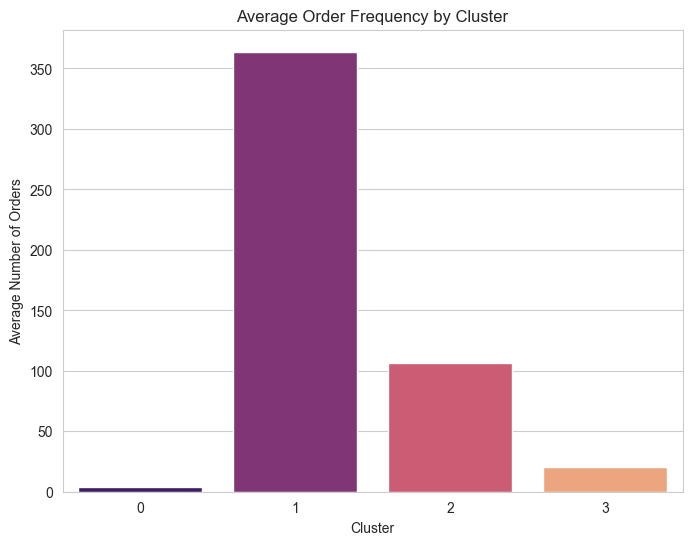

In [21]:
# Part E.3: Average order frequency per cluster
plt.figure(figsize=(8, 6))
sns.barplot(x='Cluster', y='Order_Frequency', data=customer_df, estimator=np.mean, ci=None, palette='magma')
plt.title('Average Order Frequency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Orders')
plt.show()

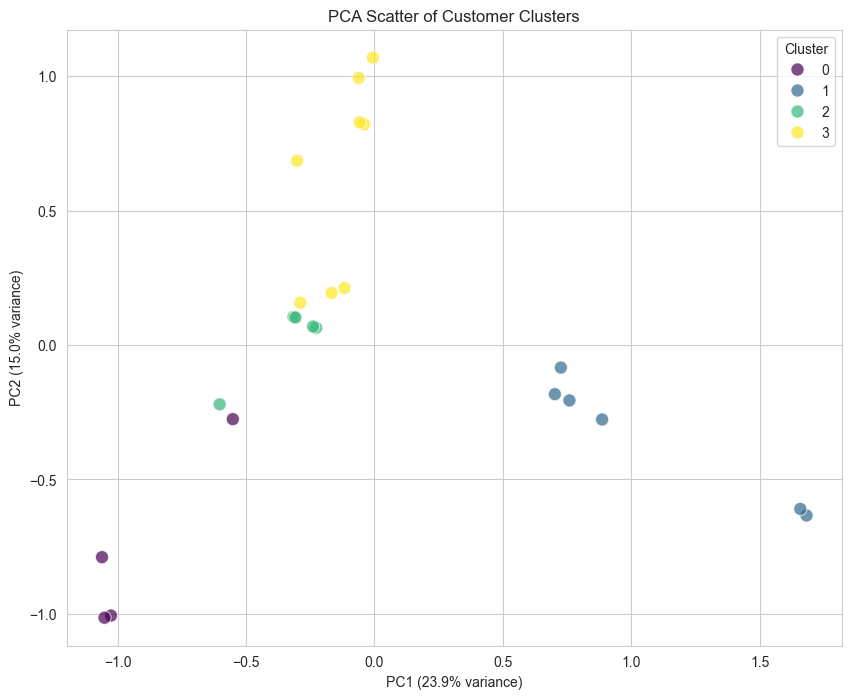

In [22]:
# Part E.4: PCA scatter plot for dashboard reuse
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    s=90,
    alpha=0.7
)
plt.title('PCA Scatter of Customer Clusters')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title='Cluster')
plt.show()

In [23]:
# Part E.5: Summary and actionable recommendations
print("## Cluster Summary & Recommended Actions")

recency_median = cluster_profile['Recency_Days'].median()
loyalty_median = cluster_profile['Loyalty_Index'].median()

for cluster_id, row in cluster_profile.iterrows():
    tier = row['Customer_Value_Tier']
    loyalty = row['Loyalty_Index']
    recency = row['Recency_Days']
    print(f"\n### Cluster {cluster_id} — {tier}")
    print(f"Customers: {int(row['Customer_Count'])}, Avg Orders: {row['Order_Frequency']}, Avg Spend: ₦{row['Purchase_Value']:.0f}")

    if tier in ['Gold', 'Platinum'] and loyalty >= loyalty_median:
        print("* **Action:** Launch VIP loyalty perks (exclusive bundles, early product drops) to retain high-value patrons.")
    elif recency > recency_median:
        print("* **Action:** Deploy reactivation campaigns (personalised emails, limited-time discounts) to win back lapsed buyers.")
    else:
        print("* **Action:** Offer cross-sell recommendations and incremental spend incentives to nurture steady buyers into premium tiers.")

## Cluster Summary & Recommended Actions

### Cluster 0 — Bronze
Customers: 4, Avg Orders: 4.0, Avg Spend: ₦49521
* **Action:** Deploy reactivation campaigns (personalised emails, limited-time discounts) to win back lapsed buyers.

### Cluster 1 — Platinum
Customers: 6, Avg Orders: 363.83, Avg Spend: ₦259222270
* **Action:** Launch VIP loyalty perks (exclusive bundles, early product drops) to retain high-value patrons.

### Cluster 2 — Silver
Customers: 5, Avg Orders: 106.2, Avg Spend: ₦2627786
* **Action:** Offer cross-sell recommendations and incremental spend incentives to nurture steady buyers into premium tiers.

### Cluster 3 — Gold
Customers: 8, Avg Orders: 20.5, Avg Spend: ₦26796832
* **Action:** Launch VIP loyalty perks (exclusive bundles, early product drops) to retain high-value patrons.


In [25]:
%pip install pandas xlsxwriter

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# ...existing code...

# Ensure these variables exist in the notebook:
# - customer_df
# - cluster_profile
# - pca_df
# - X

import xlsxwriter

output_path = Path("customer_clusters_for_powerbi.xlsx")

# Build "recommendation" per cluster using the existing logic
# This mirrors the recommendations in Part E.5
recs = []
if 'cluster_profile' in globals():
    for cluster_id, row in cluster_profile.reset_index().iterrows():
        tier = row['Customer_Value_Tier']
        loyalty = row['Loyalty_Index']
        rec = "Offer cross-sell and nurture to premium tiers."
        # Business rules copied from the notebook recommendation logic
        if pd.notna(tier) and tier in ['Gold', 'Platinum'] and loyalty >= cluster_profile['Loyalty_Index'].median():
            rec = "Launch VIP loyalty perks (exclusive bundles, early drops)."
        elif row['Recency_Days'] > cluster_profile['Recency_Days'].median():
            rec = "Deploy reactivation campaigns (personalised emails & discounts)."
        recs.append({
            "Cluster": int(row['Cluster']),
            "Customer_Value_Tier": tier,
            "Customer_Count": int(row['Customer_Count']),
            "Recommendation": rec
        })

recs_df = pd.DataFrame(recs)

# Save to Excel with multiple sheets
with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
    # Customers sheet: core columns + cluster
    cust_cols = [
        "Business Name", "Cluster", "Order_Frequency", "Purchase_Value",
        "Avg_Order_Value", "Total_Quantity", "Recency_Days", "Loyalty_Index",
        "Customer_Value_Tier", "Primary_Branch", "Primary_Region", "Primary_Local_Area"
    ]
    cust_cols = [c for c in cust_cols if c in customer_df.columns]
    customer_df.loc[:, cust_cols].to_excel(writer, sheet_name="customers", index=False)

    # Cluster profile summary
    if 'cluster_profile' in globals():
        cluster_profile.reset_index().to_excel(writer, sheet_name="cluster_profile", index=False)

    # PCA coordinates
    if 'pca_df' in globals():
        pca_cols = [c for c in ['Business Name', 'PC1', 'PC2', 'Cluster'] if c in pca_df.columns]
        pca_df.loc[:, pca_cols].to_excel(writer, sheet_name="pca", index=False)

    # Feature matrix (X) with Business Name for reference
    if 'X' in globals():
        X_export = X.copy()
        if 'Business Name' not in X_export.columns and 'Business Name' in customer_df.columns:
            X_export['Business Name'] = customer_df['Business Name'].values
        X_export.reset_index(drop=True).to_excel(writer, sheet_name="feature_matrix", index=False)

    # Actionable recommendations per cluster
    recs_df.to_excel(writer, sheet_name="recommendations", index=False)

print(f"Wrote {output_path.resolve()}")

# ...existing code...

Wrote C:\Users\Guest-User\Desktop\python  data mining\work\customer_clusters_for_powerbi.xlsx
